In [155]:
#Utilities
import pandas as pd
import numpy as np
import math 
import json
import re

import collections
from collections import defaultdict

#Plotting
import matplotlib.pyplot as plt
import plotly.express as px

#NLTK 
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

### EDA - Clean E2E Dataset

In [156]:
train = pd.read_csv('../data/e2e-cleaning-master/cleaned-data/train-fixed.no-ol.csv')
dev = pd.read_csv('../data/e2e-cleaning-master/cleaned-data/devel-fixed.no-ol.csv') 
test = pd.read_csv('../data/e2e-cleaning-master/cleaned-data/test-fixed.csv') 
print("Train Size", train.shape)
print("Dev Size", dev.shape)
print("Test Size", test.shape)

train.head()

Train Size (33525, 4)
Dev Size (4299, 4)
Test Size (4693, 4)


,mr,ref,fixed,orig_mr
0,"name[The Eagle], eatType[coffee shop], food[Ja...",The Eagle is a low rated coffee shop near Burg...,0,"name[The Eagle], eatType[coffee shop], food[Ja..."
1,"name[The Mill], eatType[coffee shop], food[Fre...",Located near The Sorrento is a French Theme ea...,1,"name[The Mill], eatType[coffee shop], food[Fre..."
2,"name[Loch Fyne], food[French], area[riverside]...","For luxurious French food, the Loch Fyne is lo...",1,"name[Loch Fyne], food[French], customer rating..."
3,"name[The Rice Boat], eatType[restaurant], food...",The Rice Boat is an adult French restaurant wi...,1,"name[The Rice Boat], food[French], customer ra..."
4,"name[The Wrestlers], eatType[coffee shop], foo...",The Wrestlers coffee shop serves Japanese food...,0,"name[The Wrestlers], eatType[coffee shop], foo..."


In [157]:
#Stopwords Set
sr= set(stopwords.words('english'))

### Example of `fixed` vs. `not fixed`

### Understand spread of MR Tags

In [158]:
#Not Fixed
print("Not Fixed:")
print(train.loc[0]['mr'])
print(train.loc[0]['orig_mr'])
print()
#Fixed
print("Fixed:")
print(train.loc[1]['mr'])
print(train.loc[1]['orig_mr'])

Not Fixed:
name[The Eagle], eatType[coffee shop], food[Japanese], priceRange[less than £20], customer rating[low], area[riverside], familyFriendly[yes], near[Burger King]
name[The Eagle], eatType[coffee shop], food[Japanese], priceRange[less than £20], customer rating[low], area[riverside], familyFriendly[yes], near[Burger King]

Fixed:
name[The Mill], eatType[coffee shop], food[French], area[riverside], near[The Sorrento]
name[The Mill], eatType[coffee shop], food[French], priceRange[£20-25], area[riverside], near[The Sorrento]


In [159]:
def get_tags(mr):
    """
    Returns list of tags for a given MR. Also appends to global dictionary to track values for analysis
    mr: single meaning representation
    """
    tag_pairs = mr.split(',')
    
    tags = []
    for pair in tag_pairs:
        tag_name, value = pair.split('[')
        
        tag_name = tag_name.strip()
        value = value[:-1]
        
        tag_values[tag_name].append(value)
        tags.append(tag_name)
    return tags

In [160]:
#Dictionary to track values that tags take on in training
tag_values = defaultdict(lambda: [])

#List of lists, of tags
all_tags = [get_tags(mr) for mr in train_mrs]

#flatten tags_total
flat_tags = [item.strip() for sublist in all_tags for item in sublist]

#Unique Tags
unique_tags = set(flat_tags)

tag_counts = collections.Counter(flat_tags)
tag_counts

Counter({'name': 33495,
         'eatType': 23141,
         'food': 26469,
         'priceRange': 20692,
         'customer rating': 20432,
         'area': 18922,
         'familyFriendly': 17706,
         'near': 14103})

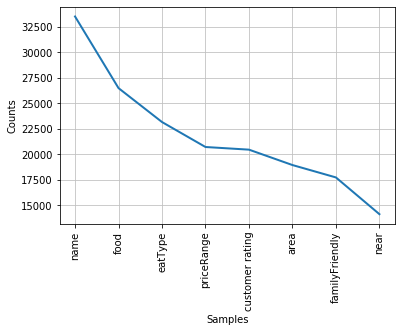

CPU times: user 218 ms, sys: 4.42 ms, total: 223 ms
Wall time: 221 ms


In [161]:
%%time
tag_clean_tokens = []
for token in flat_tags:
    if token not in sr:
        tag_clean_tokens.append(token)

freq_tag = nltk.FreqDist(tag_clean_tokens)
freq_tag.plot(20, cumulative=False)

### Understand spread of all words in MR, ignore `[`, `]`, `<any_punctuation>` and `<stopwords>`

In [162]:
%%time
def get_word_tokens(text_value):
    """
    Returns total list of tokens from the text_value
    text_value: word value that a mr tag may have
    """
    tokens = nltk.word_tokenize(text_value)
    return [word.lower() for word in tokens if word.isalpha()]

#Flatten list, one for each tag key
values = [item for sublist in list(tag_values.values()) for item in sublist] 

#List of lists, of all words
word_list = [get_word_tokens(text) for text in values]

#flatten tags_total
flat_words = [item for sublist in word_list for item in sublist]

#Unique words
unique_words = set(flat_words)

# Word counts
word_counts = collections.Counter(flat_words)

CPU times: user 10.9 s, sys: 36.2 ms, total: 10.9 s
Wall time: 10.9 s


In [163]:
#Non Stop Words
unique_words_non_stop = unique_words - sr

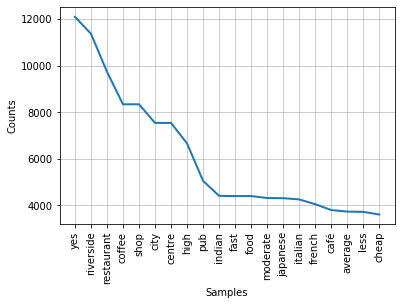

CPU times: user 293 ms, sys: 8.8 ms, total: 302 ms
Wall time: 303 ms


In [164]:
%%time
word_clean_tokens = []
for token in flat_words:
    if token not in sr:
        word_clean_tokens.append(token)

# Non-Stop Word counts
word_counts_non_stop = collections.Counter(word_clean_tokens)        

word_freq = nltk.FreqDist(word_clean_tokens)
word_freq.plot(20, cumulative=False)

In [165]:
print("Size of MR Vocab (no tags)", len(unique_words))
print("Size of MR Vocab (no tags, no stopwords)", len(word_counts_non_stop))

Size of MR Vocab (no tags) 106
Size of MR Vocab (no tags, no stopwords) 98


<hr>

### Shifting focus to the `<ref>` outputs analysis

In [166]:
train_refs = train['ref']
train_refs[0]

'The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than £20 for Japanese food.'

In [167]:
%%time
#List of lists, of all words
ref_words = [get_word_tokens(text) for text in train_refs]

#flatten tags_total
flat_ref_words = [item for sublist in ref_words for item in sublist]

#Unique words
unique_ref_words = set(flat_ref_words)

# Word counts
ref_word_counts = collections.Counter(unique_ref_words)

CPU times: user 5.52 s, sys: 33.1 ms, total: 5.55 s
Wall time: 5.56 s


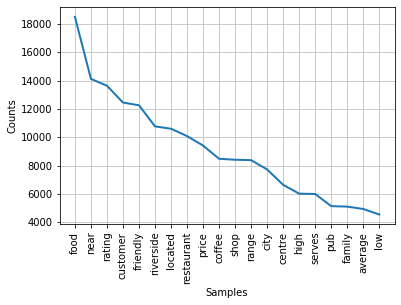

CPU times: user 488 ms, sys: 7.01 ms, total: 495 ms
Wall time: 495 ms


In [168]:
%%time
ref_word_clean_tokens = []
for token in flat_ref_words:
    if token not in sr:
        ref_word_clean_tokens.append(token)

# Non-Stop Word counts
ref_word_counts_non_stop = collections.Counter(ref_word_clean_tokens)        

word_freq = nltk.FreqDist(ref_word_clean_tokens)
word_freq.plot(20, cumulative=False)

In [169]:
print("Size of Ref Vocab", len(unique_ref_words))
print("Size of Ref Vocab (no stopwords)", len(ref_word_counts_non_stop))

Size of Ref Vocab 2019
Size of Ref Vocab (no stopwords) 1909
